#Prepare neccessary modules and open tensorflow backend, set GPU id for training.

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())
keras.backend.tensorflow_backend.get_session().run(tf.global_variables_initializer())

Using TensorFlow backend.


In [2]:
#Check the ID of GPU and if it works with tensorflow backend, this should be done in conda commandline.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

#Model building and complie it with loss function and optimizer, then generate input Generators for training and validation

In [7]:
#model build,compile and input generation
from tensorflow.keras.callbacks import TensorBoard
tensorboard=TensorBoard(log_dir="J:\logs/{}".format("Pneumonia_detection"))
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
import keras_retinanet
myRSNA=keras_retinanet.models.backbone('resnet50').retinanet(num_classes=1) 
myRSNA.compile(
    loss={
        'regression'    : keras_retinanet.losses.smooth_l1(),
        'classification': keras_retinanet.losses.focal()
    },
    optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)
)
myGenerator = CSVGenerator('input_csv_train.csv','input_class_info.csv')
myGeneratorVal = CSVGenerator('input_csv_test.csv','input_class_info.csv')

#Here is CSVGeneration provided by retinanet, we feed in csv files which contains parameters and image directory

In [ ]:
#CSV Generator
"""
Copyright 2017-2018 yhenon (https://github.com/yhenon/)
Copyright 2017-2018 Fizyr (https://fizyr.com)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""
from keras_retinanet.preproccessing.generator import Generator
from keras_retinanet.utils.image import read_image_bgr

import numpy as np
from PIL import Image
from six import raise_from

import csv
import sys
import os.path


def _parse(value, function, fmt):
    """
    Parse a string into a value, and format a nice ValueError if it fails.

    Returns `function(value)`.
    Any `ValueError` raised is catched and a new `ValueError` is raised
    with message `fmt.format(e)`, where `e` is the caught `ValueError`.
    """
    try:
        return function(value)
    except ValueError as e:
        raise_from(ValueError(fmt.format(e)), None)


def _read_classes(csv_reader):
    """ Parse the classes file given by csv_reader.
    """
    result = {}
    for line, row in enumerate(csv_reader):
        line += 1

        try:
            class_name, class_id = row
        except ValueError:
            raise_from(ValueError('line {}: format should be \'class_name,class_id\''.format(line)), None)
        class_id = _parse(class_id, int, 'line {}: malformed class ID: {{}}'.format(line))

        if class_name in result:
            raise ValueError('line {}: duplicate class name: \'{}\''.format(line, class_name))
        result[class_name] = class_id
    return result


def _read_annotations(csv_reader, classes):
    """ Read annotations from the csv_reader.
    """
    result = {}
    for line, row in enumerate(csv_reader):
        line += 1

        try:
            img_file, x1, y1, x2, y2, class_name = row[:6]
        except ValueError:
            raise_from(ValueError('line {}: format should be \'img_file,x1,y1,x2,y2,class_name\' or \'img_file,,,,,\''.format(line)), None)

        if img_file not in result:
            result[img_file] = []

        # If a row contains only an image path, it's an image without annotations.
        if (x1, y1, x2, y2, class_name) == ('', '', '', '', ''):
            continue

        x1 = _parse(x1, int, 'line {}: malformed x1: {{}}'.format(line))
        y1 = _parse(y1, int, 'line {}: malformed y1: {{}}'.format(line))
        x2 = _parse(x2, int, 'line {}: malformed x2: {{}}'.format(line))
        y2 = _parse(y2, int, 'line {}: malformed y2: {{}}'.format(line))

        # Check that the bounding box is valid.
        if x2 <= x1:
            raise ValueError('line {}: x2 ({}) must be higher than x1 ({})'.format(line, x2, x1))
        if y2 <= y1:
            raise ValueError('line {}: y2 ({}) must be higher than y1 ({})'.format(line, y2, y1))

        # check if the current class name is correctly present
        if class_name not in classes:
            raise ValueError('line {}: unknown class name: \'{}\' (classes: {})'.format(line, class_name, classes))

        result[img_file].append({'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': class_name})
    return result


def _open_for_csv(path):
    """ Open a file with flags suitable for csv.reader.
    """
    if sys.version_info[0] < 3:
        return open(path, 'rb')
    else:
        return open(path, 'r', newline='')


class CSVGenerator(Generator):
    """ Generate data for a custom CSV dataset.
    """

    def __init__(
        self,
        csv_data_file,
        csv_class_file,
        base_dir=None,
        **kwargs
    ):
        """ Initialize a CSV data generator.

        Args
            csv_data_file: Path to the CSV annotations file.
            csv_class_file: Path to the CSV classes file.
            base_dir: Directory w.r.t. where the files are to be searched (defaults to the directory containing the csv_data_file).
        """
        self.image_names = []
        self.image_data  = {}
        self.base_dir    = base_dir

        # Take base_dir from annotations file if not explicitly specified.
        if self.base_dir is None:
            self.base_dir = os.path.dirname(csv_data_file)

        # parse the provided class file
        try:
            with _open_for_csv(csv_class_file) as file:
                self.classes = _read_classes(csv.reader(file, delimiter=','))
        except ValueError as e:
            raise_from(ValueError('invalid CSV class file: {}: {}'.format(csv_class_file, e)), None)

        self.labels = {}
        for key, value in self.classes.items():
            self.labels[value] = key

        # csv with img_path, x1, y1, x2, y2, class_name
        try:
            with _open_for_csv(csv_data_file) as file:
                self.image_data = _read_annotations(csv.reader(file, delimiter=','), self.classes)
        except ValueError as e:
            raise_from(ValueError('invalid CSV annotations file: {}: {}'.format(csv_data_file, e)), None)
        self.image_names = list(self.image_data.keys())

        super(CSVGenerator, self).__init__(**kwargs)

    def size(self):
        """ Size of the dataset.
        """
        return len(self.image_names)

    def num_classes(self):
        """ Number of classes in the dataset.
        """
        return max(self.classes.values()) + 1

    def has_label(self, label):
        """ Return True if label is a known label.
        """
        return label in self.labels

    def has_name(self, name):
        """ Returns True if name is a known class.
        """
        return name in self.classes

    def name_to_label(self, name):
        """ Map name to label.
        """
        return self.classes[name]

    def label_to_name(self, label):
        """ Map label to name.
        """
        return self.labels[label]

    def image_path(self, image_index):
        """ Returns the image path for image_index.
        """
        return os.path.join(self.base_dir, self.image_names[image_index])

    def image_aspect_ratio(self, image_index):
        """ Compute the aspect ratio for an image with image_index.
        """
        # PIL is fast for metadata
        image = Image.open(self.image_path(image_index))
        return float(image.width) / float(image.height)

    def load_image(self, image_index):
        """ Load an image at the image_index.
        """
        return read_image_bgr(self.image_path(image_index))

    def load_annotations(self, image_index):
        """ Load annotations for an image_index.
        """
        path        = self.image_names[image_index]
        annotations = {'labels': np.empty((0,)), 'bboxes': np.empty((0, 4))}

        for idx, annot in enumerate(self.image_data[path]):
            annotations['labels'] = np.concatenate((annotations['labels'], [self.name_to_label(annot['class'])]))
            annotations['bboxes'] = np.concatenate((annotations['bboxes'], [[
                float(annot['x1']),
                float(annot['y1']),
                float(annot['x2']),
                float(annot['y2']),
            ]]))

        return annotations

#Set the checkpoint for the best epoch

In [22]:
mycallback=keras.callbacks.ModelCheckpoint(filepath="J:\checkpoints\weights.best.hdf5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')

#Training the model with GPU

In [23]:
myRSNA.fit_generator(generator=myGenerator,validation_data=myGeneratorVal,steps_per_epoch=100,validation_steps=10,epochs=50,verbose=1,callbacks=[mycallback])

Epoch 1/50
100/100 [==============================] - 67s 665ms/step - loss: 0.7014 - regression_loss: 0.3847 - classification_loss: 0.3166 - val_loss: 1.3497 - val_regression_loss: 0.7876 - val_classification_loss: 0.5621
Epoch 2/50
100/100 [==============================] - 66s 661ms/step - loss: 0.6332 - regression_loss: 0.3499 - classification_loss: 0.2833 - val_loss: 0.4049 - val_regression_loss: 0.2250 - val_classification_loss: 0.1799
Epoch 3/50
100/100 [==============================] - 66s 664ms/step - loss: 0.8951 - regression_loss: 0.4975 - classification_loss: 0.3976 - val_loss: 1.7316 - val_regression_loss: 1.0314 - val_classification_loss: 0.7001
Epoch 4/50
100/100 [==============================] - 66s 662ms/step - loss: 0.5988 - regression_loss: 0.3343 - classification_loss: 0.2645 - val_loss: 1.2595 - val_regression_loss: 0.7149 - val_classification_loss: 0.5446
Epoch 5/50
100/100 [==============================] - 66s 662ms/step - loss: 0.7665 - regression_loss: 0.434

#Load the Best parameters to current model

In [24]:
myRSNA.load_weights("J:\checkpoints\weights.best.hdf5")

#Save the best training model

In [25]:
#save best training model
myRSNA.save('J:\savedModel\myRSNATraining50Best.h5')

# Using the installed script to generate inference model via training model:
retinanet-convert-model /path/to/training/model.h5 /path/to/save/inference/model.h5

#Load the two trained inference model for prediction and print model summary

In [2]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

#model that I trained and then converted to an inference model:
#model_path = r"C:\Users\HASEE\Desktop\Final7390\resnet50_csv_22.h5"

model50 = load_model("J:\inferenceModel\myresnet50_csv_22_inf.h5", backbone_name='resnet50')
model101 = load_model("J:\inferenceModel\myresnet101_csv_21_inf.h5", backbone_name='resnet101')
print(model50.summary())
print(model101.summary())

# load label to names mapping for visualization purposes
labels_to_names ={0: 'Pneumonia'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
_____________________

#Draw the prediction output for two models

processing time:  4.860331058502197


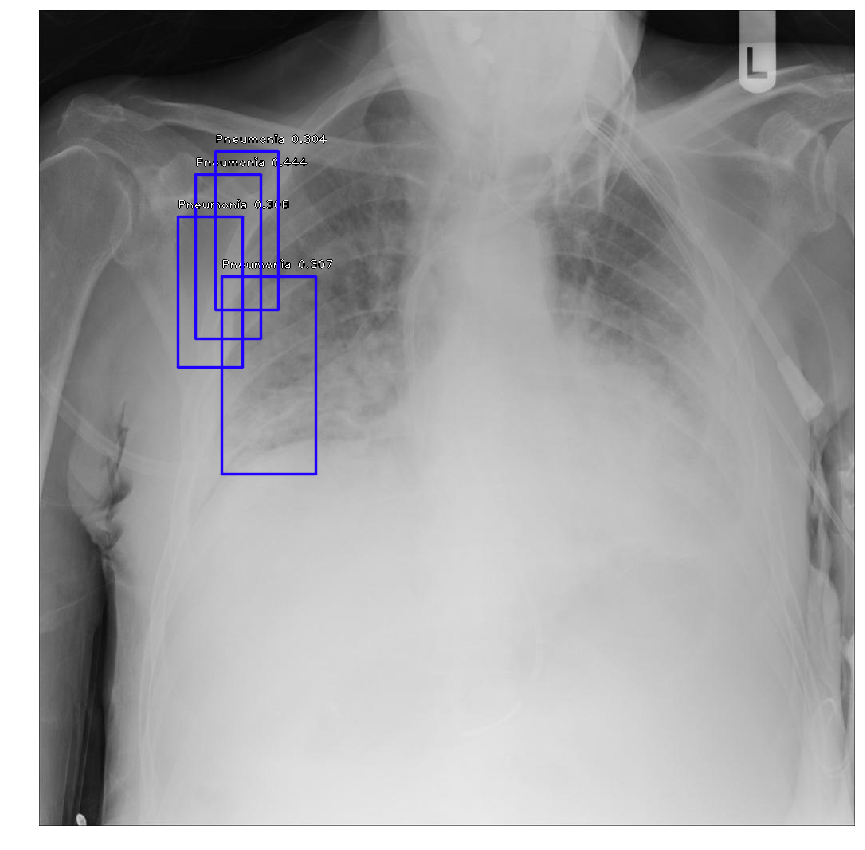

In [3]:
labels_to_names ={0: 'Pneumonia'}
# load image
image = read_image_bgr('input_jpg/4b97fa74-037a-4042-91aa-4c679535b187.dcm.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model50.predict_on_batch(np.expand_dims(image, axis=0))
boxes1, scores1, labels1 = model101.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)
#print("scores: ",scores)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.3:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
for box1, score1, label1 in zip(boxes1[0], scores1[0], labels1[0]):
    # scores are sorted so we can break
    if score1 < 0.3:
        break
        
    color1 = label_color(label1)
    
    b1 = box1.astype(int)
    draw_box(draw, b1, color=color1)
    
    caption1 = "{} {:.3f}".format(labels_to_names[label1], score1)
    draw_caption(draw, b1, caption1)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

#Weighed average these output to generated final output.

processing time:  0.621910572052002


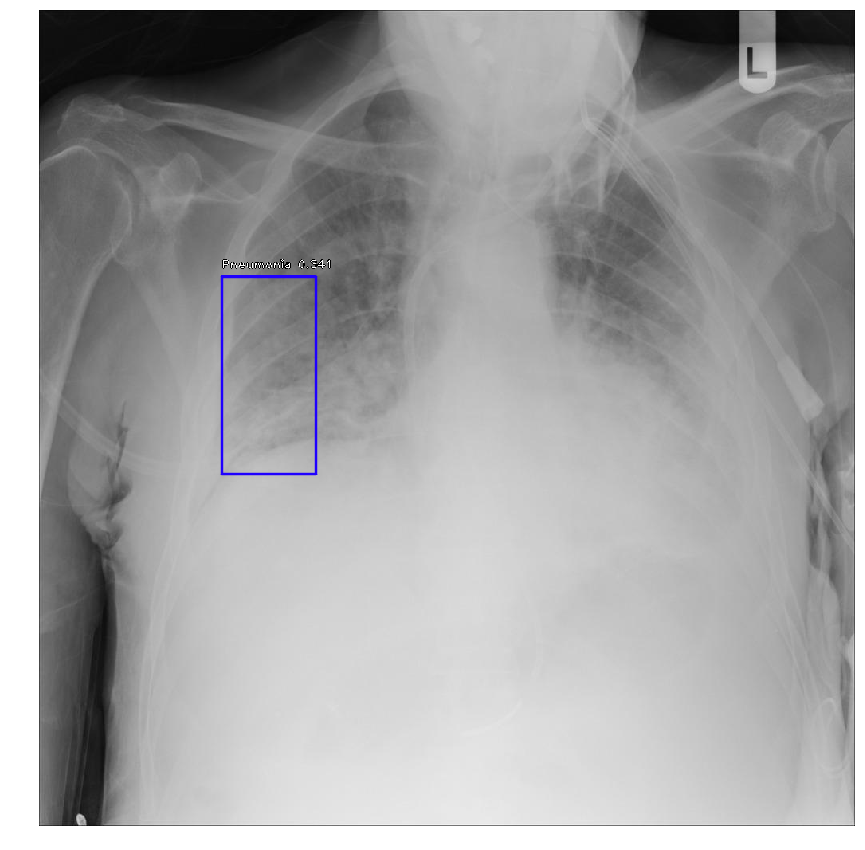

In [6]:
labels_to_names ={0: 'Pneumonia'}
# load image
image = read_image_bgr('input_jpg/4b97fa74-037a-4042-91aa-4c679535b187.dcm.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model50.predict_on_batch(np.expand_dims(image, axis=0))
boxes1, scores1, labels1 = model101.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)
#print("scores: ",scores)

# correct for image scale
boxes /= scale

#calculate total box and score
boxtotal=[]
scoretotal=0.0
scoreNum=0
# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.3:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    boxtotal+=[x*score for x in b]
    scoretotal+=score
    scoreNum+=1
    
for box1, score1, label1 in zip(boxes1[0], scores1[0], labels1[0]):
    # scores are sorted so we can break
    if score1 < 0.3:
        break
        
    color1 = label_color(label1)
    
    b1 = box1.astype(int)
    boxtotal+=[x*score1 for x in b1]
    scoretotal+=score1
    scoreNum+=1

draw_box(draw, [x/scoretotal for x in boxtotal], color=color1)
    
caption = "{} {:.3f}".format(labels_to_names[0], scoretotal/(scoreNum*1.0))
draw_caption(draw, [x/scoretotal for x in boxtotal], caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

#Copyright
Copyright 2018 Junyuan Bao, Mohao Li

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.